# Machine Learning Nanodegree Capstone

This notebook implements the pre-processing needed to generate the input for the convolutional neural network.

## Import required libraries

In [1]:
import numpy as np, h5py
import sys
import os
import tarfile
import time
import gc
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import random
from IPython.display import display, Image
from scipy import ndimage
from skimage.transform import resize
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm, tnrange, tqdm_notebook
from math import log

## Create directories to organise the files generated

In [2]:
directory = os.getcwd() + "/source_data/"
if not os.path.exists(directory):
    os.makedirs(directory)
    
temp_directory = os.getcwd() + "/temp_data/"
if not os.path.exists(temp_directory):
    os.makedirs(temp_directory)

synthetic_data_directory = os.getcwd() + "/synthetic_data/"
if not os.path.exists(synthetic_data_directory):
    os.makedirs(synthetic_data_directory)

## Download the SVHN dataset from the Internet

In [3]:
def my_hook(t):
  """
  Wraps tqdm instance. Don't forget to close() or __exit__()
  the tqdm instance once you're done with it (easiest using `with` syntax).

  Example
  -------

  >>> with tqdm(...) as t:
  ...     reporthook = my_hook(t)
  ...     urllib.urlretrieve(..., reporthook=reporthook)

  """
  last_b = [0]

  def inner(b=1, bsize=1, tsize=None):
    """
    b  : int, optional
        Number of blocks just transferred [default: 1].
    bsize  : int, optional
        Size of each block (in tqdm units) [default: 1].
    tsize  : int, optional
        Total size (in tqdm units). If [default: None] remains unchanged.
    """
    if tsize is not None:
        t.total = tsize
    t.update((b - last_b[0]) * bsize)
    last_b[0] = b
  return inner

In [4]:
url = 'http://ufldl.stanford.edu/housenumbers/'

    
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  file_save_location = directory + filename
  if force or not os.path.exists(file_save_location):
    #filename, _ = urlretrieve(url + filename, file_save_location)
    with tqdm(unit='B', unit_scale=True, miniters=1,
          desc="Downloading: "+filename) as t:  # all optional kwargs
        filename, _ = urlretrieve(url + filename, file_save_location, 
                                  reporthook=my_hook(t), data=None)
  statinfo = os.stat(file_save_location)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return file_save_location

test_filename = maybe_download('test.tar.gz', 276555967)
train_filename = maybe_download('train.tar.gz', 404141560)

('Found and verified', 'test.tar.gz')
('Found and verified', 'train.tar.gz')


## Extract the Raw SVHN image data

If the .tar.gz file downloaded above has not been extracted, then the code below will extract it

In [5]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(path=directory)
    tar.close()
  image_names = [d for d in sorted(os.listdir(root))]
  return len(image_names) , root
  
num_train_images , train_folder = maybe_extract(train_filename)
num_test_images , test_folder = maybe_extract(test_filename)

print("Number of training files in ["+train_folder+"] = " + str(num_train_images))
print("Number of test files in ["+test_folder+"] = " + str(num_test_images))

/home/xjera/wills/tensorflow/svhn2/source_data/train already present - Skipping extraction of /home/xjera/wills/tensorflow/svhn2/source_data/train.tar.gz.
/home/xjera/wills/tensorflow/svhn2/source_data/test already present - Skipping extraction of /home/xjera/wills/tensorflow/svhn2/source_data/test.tar.gz.
Number of training files in [/home/xjera/wills/tensorflow/svhn2/source_data/train] = 33404
Number of test files in [/home/xjera/wills/tensorflow/svhn2/source_data/test] = 13070


## Processing the bounding box information for the train and test set images

The below code is used to process the digitStruct files that come with the SVHN image files. The code extracts the bounding box information for each digit in the image and combines them into a bounding box for a the entire multi-digit house number. It puts these into a dictionary that has the file names as keys and the bounding box information as values. It pickles the dictionary for convenient use later.

In [13]:
def merge_two_dicts(x, y):
    '''Given two dicts, merge them into a new dict as a shallow copy.'''
    z = x.copy()
    z.update(y)
    return z

def calculate_total_bbox(digit_bboxes):
    lefts = set()
    tops = set()
    bottoms = set()
    rights = set()
    full_number_list = []
	# some code to populate the sets
    for bbox in digit_bboxes:
		lefts.add(bbox['left'])
		rights.add(bbox['left']+bbox['width'])
		bottoms.add(bbox['top']+bbox['height'])
		tops.add(bbox['top'])
		full_number_list.append(str(int(bbox['label'])))
    full_number = int(''.join(full_number_list))
    return {'left':min(lefts), 'top':min(tops), 'right':max(rights), 'bottom':max(bottoms),'label':full_number}


# Credits to https://github.com/hangyao/ for the below class DigitStructFile, I modified it slightly for my needs

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
        #return [self.getDigitStructure(i) for i in range(10)]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        result2 = reduce(lambda d1,d2: merge_two_dicts(d1,d2),
            map(lambda x: {x['filename']: calculate_total_bbox(x['boxes'])},
            result))
        return result2

In [14]:
def maybe_extract_bounding_box_data():
  """Create the bounding box picle files if not present"""
  if not (os.path.exists("./temp_data/test_bboxes.pickle") and os.path.exists("./temp_data/train_bboxes.pickle")):
    # Extract the total bounding box data for the test set and save to a Pickle file for use later
    print("Starting to extract the bounding box data for the Test set")
    dsf = DigitStructFile("./source_data/test/digitStruct.mat")
    bbox_data = dsf.getAllDigitStructure_ByDigit()
    print("....The number of bounding box records for the Test set is : "+ str(len(bbox_data)))

    set_filename = "./temp_data/test_bboxes.pickle"
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(bbox_data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
    print("....pickled complete Test bbox data set")


    # Extract the total bounding box data for the train set and save to a Pickle file for use later
    print("Starting to extract the bounding box data for the Train set")
    dsf = DigitStructFile("./source_data/train/digitStruct.mat")
    bbox_data = dsf.getAllDigitStructure_ByDigit()
    print("....The number of bounding box records for the Train set is : "+ str(len(bbox_data)))

    set_filename = "./temp_data/train_bboxes.pickle"
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(bbox_data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
    print("....pickled complete Train bbox data set")
    
  else:
    print("The Digit structs have already been extracted into pickle files for the train and test data")
  return "Done"

In [15]:
maybe_extract_bounding_box_data()

The Digit structs have already been extracted into pickle files for the train and test data


'Done'

### Let's now use the bounding box data by unpickling the files generated above

In [16]:
test_bbox_info_file = open("./temp_data/test_bboxes.pickle",'r')
test_bboxes_dict = pickle.load(test_bbox_info_file)

train_bbox_info_file = open("./temp_data/train_bboxes.pickle",'r')
train_bboxes_dict = pickle.load(train_bbox_info_file)

### Processing the raw images

Here we open each of the raw images and convert them into ndarrays. Then we do some normalisation of the data. We then crop and scale the images into 54x54 images containing only the housenumbers. We use the bounding box information obtained above to do this cropping.

In [11]:
image_size = 54  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
color_channels = 3 # since we are using color images

def crop_and_scale(imagedata,image_filename,bbox_dict):
    image_bbox = bbox_dict[image_filename]
    
    top = int(max(0,image_bbox['top']))
    bottom = int(max(0,image_bbox['bottom']))
    left = int(max(0,image_bbox['left']))
    right = int(max(0,image_bbox['right']))
    
    width = right - left
    height = bottom - top
    
    top = int(max(0,top-(0.15*height)))
    bottom = int(max(0,bottom+(0.15*height)))
    left = int(max(0,left-(0.15*width)))
    right = int(max(0,right+(0.15*width)))
    
    cropped = imagedata[top:bottom,left:right,:]
    scaled = resize(np.ascontiguousarray(cropped),(64,64))
    
    randomTop = random.choice(range(10))
    randomLeft = random.choice(range(10))
    
    final_image = scaled[randomTop:54+randomTop,randomLeft:54+randomLeft,:]
    return final_image

def load_imagadata(folder, bbox_dict):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size, color_channels),
                         dtype=np.float32)
  labels = np.ndarray(shape=(len(image_files)),dtype=np.int)
  image_index = 0
  print("Processing images in the folder: " + folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      cropped_and_scaled = crop_and_scale(image_data,image,bbox_dict)
      if cropped_and_scaled.shape != (image_size, image_size, color_channels):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :,:] = cropped_and_scaled
      labels[image_index] = bbox_dict[image]['label']
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset, labels

test_dataset, test_labels = load_imagadata(test_folder,test_bboxes_dict)
train_dataset, train_labels = load_imagadata(train_folder,train_bboxes_dict)

Processing images in the folder: /home/xjera/wills/tensorflow/svhn2/source_data/test


/home/xjera/anaconda2/envs/tensorflow/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


('Could not read:', '/home/xjera/wills/tensorflow/svhn2/source_data/test/digitStruct.mat', ':', IOError("cannot identify image file '/home/xjera/wills/tensorflow/svhn2/source_data/test/digitStruct.mat'",), "- it's ok, skipping.")
('Could not read:', '/home/xjera/wills/tensorflow/svhn2/source_data/test/see_bboxes.m', ':', IOError("cannot identify image file '/home/xjera/wills/tensorflow/svhn2/source_data/test/see_bboxes.m'",), "- it's ok, skipping.")
('Full dataset tensor:', (13068, 54, 54, 3))
('Mean:', -0.043409485)
('Standard deviation:', 0.22367825)
Processing images in the folder: /home/xjera/wills/tensorflow/svhn2/source_data/train
('Could not read:', '/home/xjera/wills/tensorflow/svhn2/source_data/train/digitStruct.mat', ':', IOError("cannot identify image file '/home/xjera/wills/tensorflow/svhn2/source_data/train/digitStruct.mat'",), "- it's ok, skipping.")
('Could not read:', '/home/xjera/wills/tensorflow/svhn2/source_data/train/see_bboxes.m', ':', IOError("cannot identify imag

### Let's take a look at a sample processed image

4


<function matplotlib.pyplot.show>

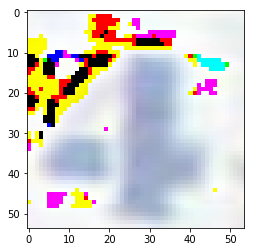

In [12]:
print(train_labels[5])

%matplotlib inline
plt.figure()
plt.imshow(train_dataset[5]);
plt.show

### Pickling the processed SVHN dataset for convenient use later on

In [17]:
set_filename = "./temp_data/test_dataset.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(test_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled test dataset")

set_filename = "./temp_data/test_labels.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(test_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled test labels")


set_filename = "./temp_data/train_dataset.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(train_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled train dataset")

set_filename = "./temp_data/train_labels.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(train_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled train labels")

pickled test dataset
pickled test labels
pickled train dataset
pickled train labels


## Generating a synthetic dataset for initial training of the neural network

We first generate some synthetic raw images using the code below

In [3]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
def calculate_font_size(housenumber):
    if housenumber >= 10000:
        fontsize = 100
    elif housenumber >= 1000:
        fontsize = 150
    elif housenumber >= 100:
        fontsize = 200
    elif housenumber >= 10:
        fontsize = 250
    else:
        fontsize = 300
    return fontsize
        
def make_housenumber_sample(housenumber_config):
    fig = plt.figure(figsize=(5.4, 5.4), dpi=10)
    ax = fig.add_subplot(111)
    font = FontProperties()
    font.set_family(housenumber_config['family'])
    font.set_style(housenumber_config['style'])
    ax.text(0.5, 0.5, housenumber_config['random_number'],
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transAxes,
        color=housenumber_config['color'], fontsize=calculate_font_size(housenumber_config['random_number']), fontproperties=font, rotation=housenumber_config['rotation'])
    ax.axis([0, 54, 0, 54])
    plt.axis('off')
    #fig.show()
    fig.savefig(housenumber_config['filename'],dpi=10)
    fig.clf()
    plt.close()
    gc.collect()
    

def generate_synthetic_housenumbers(num_samples=1, fileprefix='shn'):
    list_of_hnconfig_tuples = [
                        (
                            synthetic_data_directory + fileprefix + '/' + fileprefix + '-' + str(x),
                            random.choice(['sans-serif','serif']),
                            random.choice(['italic','normal']),
                            random.choice(['orange','red','blue','black','green']),
                            random.choice([0,-20,-10,-5,5,10,20]),
                            random.choice(range(random.choice([100,1000,10000,99999])))+1
                        ) 
                        for x in range(num_samples)
                        ]
    list_of_hnconfig_dicts = map(
                            lambda (filename,family,style,color,rotation,random_number):
                            {'filename':filename,
                             'family':family,
                             'style':style,
                             'color':color,
                             'rotation':rotation,
                             'random_number':random_number
                            },list_of_hnconfig_tuples
                            )
    labels = map(
                lambda (filename,family,style,color,rotation,random_number):
                random_number,
                list_of_hnconfig_tuples
                )

    os.mkdir(synthetic_data_directory+fileprefix)
    print("Generating images....")
    for hnconfig in list_of_hnconfig_dicts:
        #print(hnconfig)
        make_housenumber_sample(hnconfig)
    make_tarfile(synthetic_data_directory+fileprefix+'.tar.gz',synthetic_data_directory+fileprefix)
    
    set_filename = synthetic_data_directory+fileprefix+'-labels.pickle'
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(labels, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
        
    print("Done generating "+str(num_samples)+" images")

In [8]:
def maybe_generate_synthetic_images():
  """Genetate the synthetic datasets used to initially train the neural network"""
  if not (os.path.exists("./synthetic_data/synthetic_test_set.tar.gz") and 
          os.path.exists("./synthetic_data/synthetic_train_set.tar.gz")):
#     print("Starting to generate synthetic_test_set...")
#     start = time.clock() 
#     generate_synthetic_housenumbers(num_samples=15000,fileprefix='synthetic_test_set')
#     elapsed = time.clock()
#     elapsed = elapsed - start
#     print "Time spent was: ", elapsed

    print("Starting to generate synthetic_train_set...")
    start = time.clock() 
    generate_synthetic_housenumbers(num_samples=35000,fileprefix='synthetic_train_set')
    elapsed = time.clock()
    elapsed = elapsed - start
    print "Time spent is: ", elapsed
  else:
    print("The synthetic images have been created already so skipping generation...")
  print("The synthetic images are ready")
  return "synthetic_train_set", "synthetic_test_set"

synthetic_train_folder, synthetic_test_folder =  maybe_generate_synthetic_images()

The synthetic images have been created already so skipping generation...
The synthetic images are ready


### Let's now pre-process the synthetic images in the same way we did for the SVHN images

In [6]:
def merge_two_dicts(x, y):
    '''Given two dicts, merge them into a new dict as a shallow copy.'''
    z = x.copy()
    z.update(y)
    return z

stestlf = open(synthetic_data_directory+'synthetic_test_set-labels.pickle','r')
synthetic_test_labels_list = pickle.load(stestlf)

strainlf = open(synthetic_data_directory+'synthetic_train_set-labels.pickle','r')
synthetic_train_labels_list = pickle.load(strainlf)

synthetic_test_labels_dict = reduce(lambda d1,d2: merge_two_dicts(d1,d2),
                                    map(lambda (x,y):{'synthetic_test_set-'+str(x)+'.png':y},
                                 zip(range(len(synthetic_test_labels_list)),synthetic_test_labels_list)))

synthetic_train_labels_dict = reduce(lambda d1,d2: merge_two_dicts(d1,d2),
                                     map(lambda (x,y):{'synthetic_train_set-'+str(x)+'.png':y},
                                 zip(range(len(synthetic_train_labels_list)),synthetic_train_labels_list)))

In [9]:
image_size = 54  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
color_channels = 3 # since we are using color images

def load_synthetic_imagadata(folder,label_dict):
  """Load the data for a single letter label."""
  image_files = os.listdir(synthetic_data_directory+folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size, color_channels),
                         dtype=np.float32)
  labels = np.ndarray(shape=(len(image_files)),dtype=np.int)
  image_index = 0
  print("Processing images in the folder: " + folder)
  for image in sorted(os.listdir(synthetic_data_directory+folder)):
    image_file = os.path.join(synthetic_data_directory+folder, image)
    try:
      img = Image.open(image_file).convert("RGB")
      image_data = (np.array(img) - pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size, color_channels):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :,:] = image_data
      labels[image_index] = label_dict[image]
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset, labels
    
synthetic_test_dataset, synthetic_test_labels = load_synthetic_imagadata(synthetic_test_folder, synthetic_test_labels_dict)
synthetic_train_dataset, synthetic_train_labels= load_synthetic_imagadata(synthetic_train_folder, synthetic_train_labels_dict)

Processing images in the folder: synthetic_test_set
('Full dataset tensor:', (15000, 54, 54, 3))
('Mean:', 0.43546253)
('Standard deviation:', 0.21209499)
Processing images in the folder: synthetic_train_set
('Full dataset tensor:', (35000, 54, 54, 3))
('Mean:', 0.43539909)
('Standard deviation:', 0.21228784)


### Pickling the processed Synthetic dataset for convenient use later on

In [10]:
set_filename = synthetic_data_directory+"synthetic_test_dataset.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_test_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic test dataset")

set_filename = synthetic_data_directory+"synthetic_test_labels.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_test_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic test labels")

set_filename = synthetic_data_directory+"synthetic_train_dataset.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_train_dataset, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic train dataset")

set_filename = synthetic_data_directory+"synthetic_train_labels.pickle"
try:
    with open(set_filename, 'wb') as f:
        pickle.dump(synthetic_train_labels, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
print("pickled synthetic train labels")

pickled synthetic test dataset
pickled synthetic test labels
pickled synthetic train dataset
pickled synthetic train labels


671


<function matplotlib.pyplot.show>

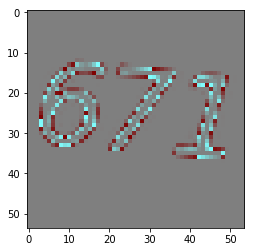

In [12]:
print(synthetic_train_labels[110])

%matplotlib inline
plt.figure()
plt.imshow(synthetic_train_dataset[110]);
plt.show

### Package all the datasets and labels together into a single collection for further processing by the CNN

In [13]:
train_dataset_file = open(synthetic_data_directory+'synthetic_train_dataset.pickle','r')
source_train_dataset = pickle.load(train_dataset_file)

train_labels_file = open(synthetic_data_directory+'synthetic_train_labels.pickle','r')
source_train_labels = np.asarray(pickle.load(train_labels_file))

test_dataset_file = open(synthetic_data_directory+'synthetic_test_dataset.pickle','r')
test_dataset = pickle.load(test_dataset_file)

test_labels_file = open(synthetic_data_directory+'synthetic_test_labels.pickle','r')
test_labels_1 = np.asarray(pickle.load(test_labels_file))

trainlen = int(0.8 * len(source_train_dataset))

valid_dataset = source_train_dataset[trainlen:,:,:,:]
valid_labels_1 = source_train_labels[trainlen:]

train_dataset = source_train_dataset[:trainlen,:,:,:]
train_labels_1 = source_train_labels[:trainlen]

train_dataset_save = train_dataset
train_labels_save = train_labels_1
valid_dataset_save = valid_dataset
valid_labels_save = valid_labels_1
test_dataset_save = test_dataset
test_labels_save = test_labels_1

In [14]:
pickle_file = 'SVHN_synthetic.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_save,
    'train_labels': train_labels_save,
    'valid_dataset': valid_dataset_save,
    'valid_labels': valid_labels_save,
    'test_dataset': test_dataset_save,
    'test_labels': test_labels_save,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 1750000516)


In [15]:
train_dataset_file = open(temp_directory+'train_dataset.pickle','r')
source_train_dataset = pickle.load(train_dataset_file)

train_labels_file = open(temp_directory+'train_labels.pickle','r')
source_train_labels = np.asarray(pickle.load(train_labels_file))

test_dataset_file = open(temp_directory+'test_dataset.pickle','r')
test_dataset = pickle.load(test_dataset_file)

test_labels_file = open(temp_directory+'test_labels.pickle','r')
test_labels_1 = np.asarray(pickle.load(test_labels_file))

trainlen = int(0.8 * len(source_train_dataset))

valid_dataset = source_train_dataset[trainlen:,:,:,:]
valid_labels_1 = source_train_labels[trainlen:]

train_dataset = source_train_dataset[:trainlen,:,:,:]
train_labels_1 = source_train_labels[:trainlen]

train_dataset_save = train_dataset
train_labels_save = train_labels_1
valid_dataset_save = valid_dataset
valid_labels_save = valid_labels_1
test_dataset_save = test_dataset
test_labels_save = test_labels_1

In [16]:
pickle_file = 'SVHN_real.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_save,
    'train_labels': train_labels_save,
    'valid_dataset': valid_dataset_save,
    'valid_labels': valid_labels_save,
    'test_dataset': test_dataset_save,
    'test_labels': test_labels_save,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 1626450516)
